# Đề tài: Phân loại mức độ đánh giá xe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cài đặt thư viện

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.svm import SVC
import numpy as np

## Data Loader

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BTL_KPDL/car_evaluation.csv', header=None)
# df = pd.read_csv('car_evaluation.csv')

df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "decision"]

df.head()

,buying,maint,doors,persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Tiền xử lý dữ liệu

### Khám phá và làm sạch dữ liệu

In [ ]:
# Kiểm tra thông tin dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   decision  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


,buying,maint,doors,persons,lug_boot,safety,decision
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [ ]:
# Kiểm tra giá trị thiếu
df.isnull().sum()

,0
buying,0
maint,0
doors,0
persons,0
lug_boot,0
safety,0
decision,0


In [ ]:
# Kiểm tra duplicate
print("Số bản ghi duplicate:", df.duplicated().sum())

# Xóa duplicates nếu có
df = df.drop_duplicates()

Số bản ghi duplicate: 0


In [ ]:
# Thống kê giá trị của từng thuộc tính
for col in df.columns:
    print(col, df[col].unique())

buying ['vhigh' 'high' 'med' 'low']
maint ['vhigh' 'high' 'med' 'low']
doors ['2' '3' '4' '5more']
persons ['2' '4' 'more']
lug_boot ['small' 'med' 'big']
safety ['low' 'med' 'high']
decision ['unacc' 'acc' 'vgood' 'good']


### Mã hóa dữ liệu (Encoding)

In [ ]:
ordinal_cols = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

df[ordinal_cols] = df[ordinal_cols].astype(str)

encoder = OrdinalEncoder(
    categories=[
        ['low', 'med', 'high', 'vhigh'],   # buying
        ['low', 'med', 'high', 'vhigh'],   # maint
        ['2', '3', '4', '5more'],          # doors
        ['2', '4', 'more'],                # persons
        ['small', 'med', 'big'],           # lug_boot
        ['low', 'med', 'high']             # safety
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])
class_names = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}
df['decision'] = df['decision'].map(class_names)



df.head()

,buying,maint,doors,persons,lug_boot,safety,decision
0,3.0,3.0,0.0,0.0,0.0,0.0,0
1,3.0,3.0,0.0,0.0,0.0,1.0,0
2,3.0,3.0,0.0,0.0,0.0,2.0,0
3,3.0,3.0,0.0,0.0,1.0,0.0,0
4,3.0,3.0,0.0,0.0,1.0,1.0,0


### Chia tập dữ liệu

In [ ]:
X = df.drop('decision', axis=1)
y = df['decision']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(len(X_train), len(X_test))

1382 346


### Chuẩn hóa dữ liệu

In [ ]:
# Dùng nếu sử dụng mô hình Logistic Regression, SVM, KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Kiểm tra độ cân bằng dữ liệu


Tổng số mẫu: 1728
Số lượng class: 4

------------------------------------------------------------
 Class  Số lượng  Tỷ lệ (%) Tên Class
     0      1210      70.02     unacc
     1       384      22.22       acc
     2        69       3.99      good
     3        65       3.76     vgood
------------------------------------------------------------

Class đa số: 1210 mẫu (70.02%)
Class thiểu số: 65 mẫu (3.76%)
Imbalance Ratio: 18.62:1


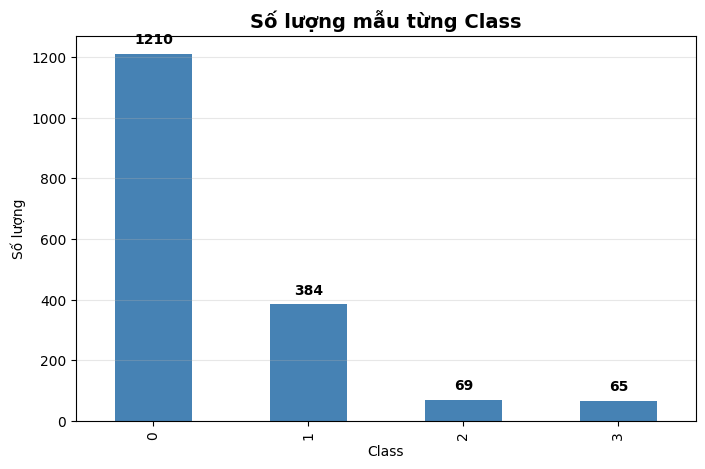

In [ ]:
y = df['decision']  # cột target

# 1. Đếm số lượng mẫu từng class
counts = y.value_counts().sort_index()
total = len(y)

print(f"\nTổng số mẫu: {total}")
print(f"Số lượng class: {len(counts)}")
print("\n" + "-"*60)

# 2. Bảng thống kê
df_stats = pd.DataFrame({
    'Class': counts.index,
    'Số lượng': counts.values,
    'Tỷ lệ (%)': (counts.values / total * 100).round(2)
})

class_names = {0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}
df_stats['Tên Class'] = [class_names[i] for i in df_stats['Class']]

print(df_stats.to_string(index=False))
print("-"*60)

# 3. Tính Imbalance Ratio
max_count = counts.max()
min_count = counts.min()
ratio = max_count / min_count

print(f"\nClass đa số: {max_count} mẫu ({max_count/total*100:.2f}%)")
print(f"Class thiểu số: {min_count} mẫu ({min_count/total*100:.2f}%)")
print(f"Imbalance Ratio: {ratio:.2f}:1")

# 4. Visualization
fig, ax = plt.subplots(figsize=(8,5))

# Bar plot
counts.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Số lượng mẫu từng Class', fontsize=14, fontweight='bold')
ax.set_xlabel('Class')
ax.set_ylabel('Số lượng')
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(counts.values):
    ax.text(i, v + max_count*0.02, str(v),
            ha='center', va='bottom', fontweight='bold')

plt.show()

### Xử lý imbalanced data

In [ ]:
# Phương pháp Class Weights
clf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)

# Thuật toán Decision Tree & Random Forest

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree accuracy: 0.976878612716763
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       242
           1       0.96      0.94      0.95        77
           2       0.92      0.86      0.89        14
           3       1.00      1.00      1.00        13

    accuracy                           0.98       346
   macro avg       0.97      0.95      0.96       346
weighted avg       0.98      0.98      0.98       346



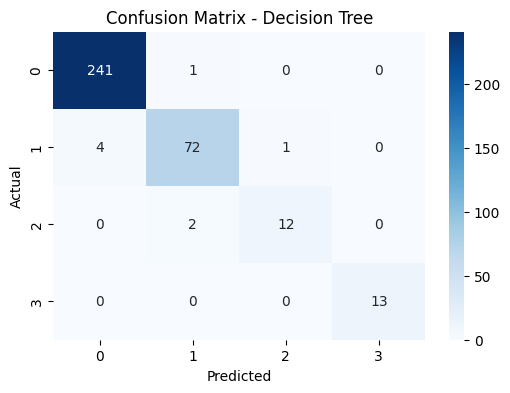

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


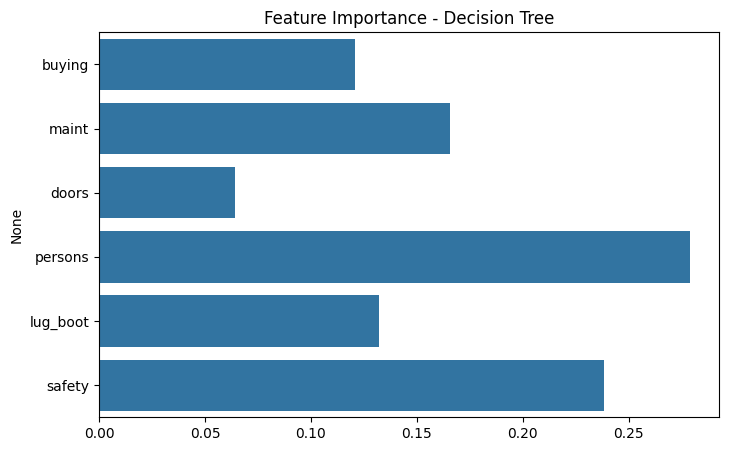

In [ ]:
importances_dt = dt.feature_importances_
features = X.columns # Define features here

plt.figure(figsize=(8,5))
sns.barplot(x=importances_dt, y=features)
plt.title("Feature Importance - Decision Tree")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest accuracy: 0.9710982658959537
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       242
           1       0.93      0.96      0.94        77
           2       1.00      0.79      0.88        14
           3       0.86      0.92      0.89        13

    accuracy                           0.97       346
   macro avg       0.94      0.91      0.93       346
weighted avg       0.97      0.97      0.97       346



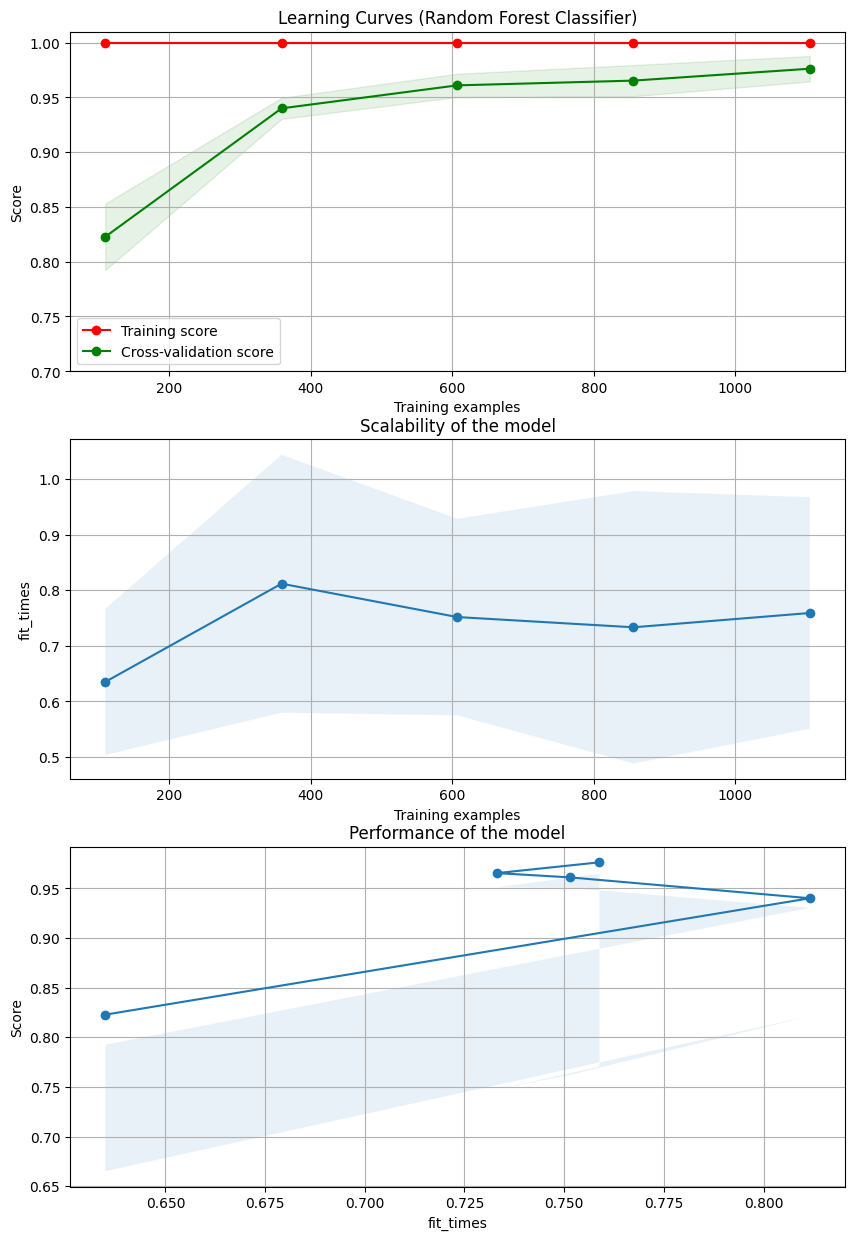

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np # Import numpy

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs. fit times curve, the fit times vs. score curve.
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         fit_times_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning Curves (Random Forest Classifier)"
plot_learning_curve(rf, title, X_train, y_train, axes=axes, ylim=(0.7, 1.01), cv=5, n_jobs=-1)

plt.show()

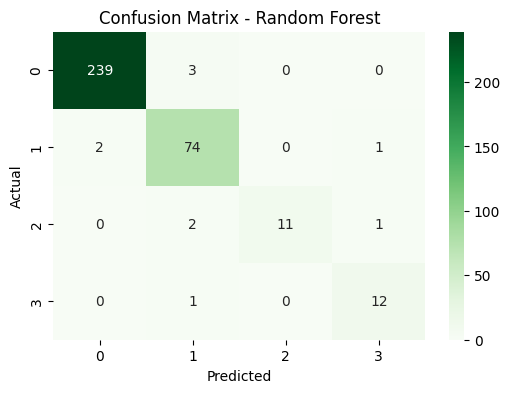

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


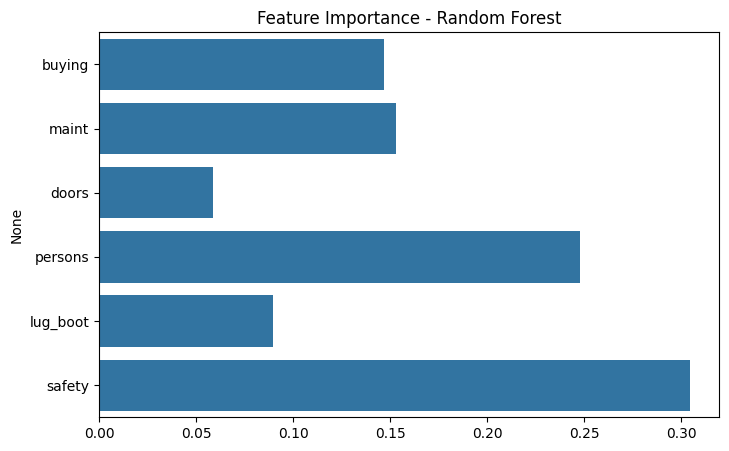

In [ ]:
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - Random Forest")
plt.show()


## So sánh 2 thuật toán

In [ ]:
# plt.figure(figsize=(6,4))
# accuracies = [acc_dt, acc_rf]
# labels = ["Decision Tree", "Random Forest"]

# bars = plt.bar(labels, accuracies)

# plt.title("Accuracy Comparison")
# plt.ylabel("Accuracy")

# # Ghi giá trị trên đầu cột
# for bar, acc in zip(bars, accuracies):
#     plt.text(
#         bar.get_x() + bar.get_width() / 2,
#         bar.get_height() + 0.005,
#         f"{acc*100:.2f}%",
#         ha='center', fontsize=12
#     )

# plt.ylim(0.9, 1)  # zoom để thấy rõ sự khác biệt
# plt.show()


##

# Thuật toán Gradient Boosting và Support Vector Machine (SVM)

## Gradient Boosting


Accuracy: 0.9913
F1-Score (weighted): 0.9909

Classification Report:
              precision    recall  f1-score   support

       unacc       1.00      1.00      1.00       242
         acc       0.96      1.00      0.98        77
        good       1.00      0.79      0.88        14
       vgood       1.00      1.00      1.00        13

    accuracy                           0.99       346
   macro avg       0.99      0.95      0.97       346
weighted avg       0.99      0.99      0.99       346



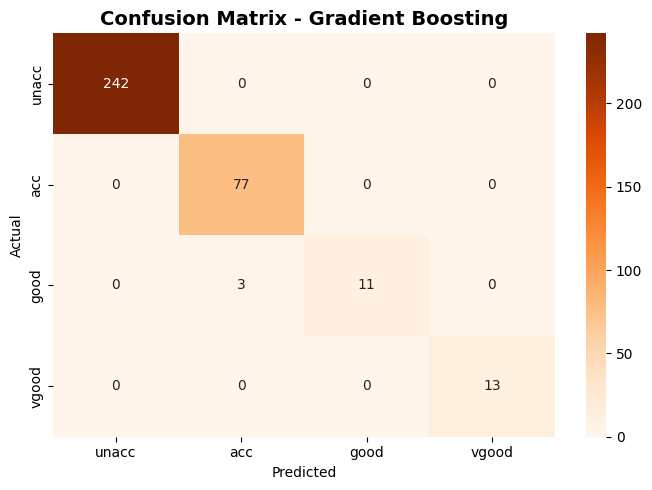

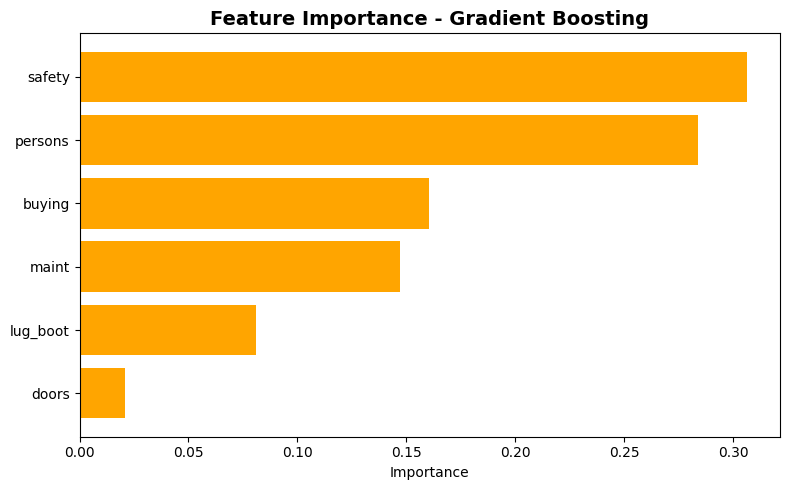

In [ ]:
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    random_state=42,
    subsample=0.8
)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

print(f"\nAccuracy: {acc_gb:.4f}")
print(f"F1-Score (weighted): {f1_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb,
                          target_names=[class_names[i] for i in sorted(class_names.keys())]))

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(7,5))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Oranges",
            xticklabels=[class_names[i] for i in sorted(class_names.keys())],
            yticklabels=[class_names[i] for i in sorted(class_names.keys())])
plt.title("Confusion Matrix - Gradient Boosting", fontsize=14, fontweight='bold')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature Importance
importances_gb = gb.feature_importances_

features = X_train.columns

plt.figure(figsize=(8,5))
feature_imp_gb = pd.DataFrame({
    'feature': features,
    'importance': importances_gb
}).sort_values('importance', ascending=True)

plt.barh(feature_imp_gb['feature'], feature_imp_gb['importance'], color='orange')
plt.title("Feature Importance - Gradient Boosting", fontsize=14, fontweight='bold')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Support Vector Machine (SVM)


Accuracy: 0.9827
F1-Score (weighted): 0.9829

Classification Report:
              precision    recall  f1-score   support

       unacc       1.00      0.98      0.99       242
         acc       0.93      1.00      0.96        77
        good       1.00      1.00      1.00        14
       vgood       1.00      1.00      1.00        13

    accuracy                           0.98       346
   macro avg       0.98      0.99      0.99       346
weighted avg       0.98      0.98      0.98       346



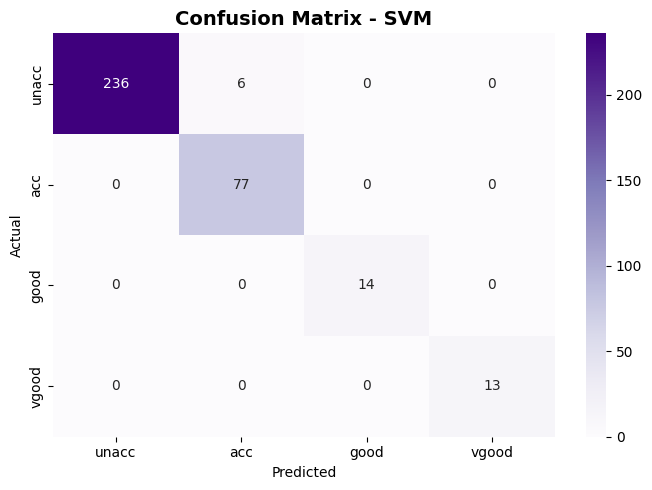

In [ ]:
# SVM cần dữ liệu được chuẩn hóa
svm = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True
)
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print(f"\nAccuracy: {acc_svm:.4f}")
print(f"F1-Score (weighted): {f1_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm,
                          target_names=[class_names[i] for i in sorted(class_names.keys())]))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(7,5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Purples",
            xticklabels=[class_names[i] for i in sorted(class_names.keys())],
            yticklabels=[class_names[i] for i in sorted(class_names.keys())])
plt.title("Confusion Matrix - SVM", fontsize=14, fontweight='bold')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


  0%|          | 0/300 [00:00<?, ?it/s]

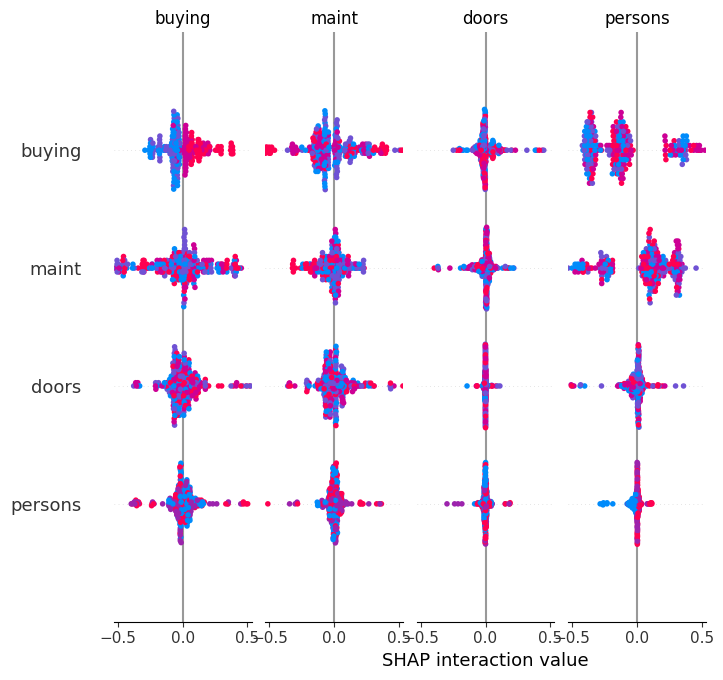

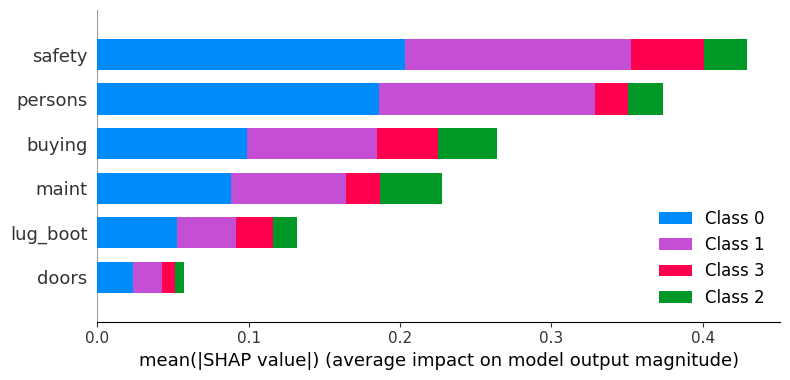

In [ ]:
import shap

# --- SHAP cho SVM ---
# Lấy mẫu background để tăng tốc độ tính SHAP
X_background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 200, replace=False)]

explainer = shap.KernelExplainer(svm.predict_proba, X_background)
shap_values = explainer.shap_values(X_test_scaled[:300])   # tính cho 300 mẫu test để nhanh hơn

# Tên features
feature_names = X.columns if hasattr(X, 'columns') else [f"f{i}" for i in range(X.shape[1])]

# --- Summary Plot (tổng quan mức độ ảnh hưởng mỗi feature) ---
shap.summary_plot(shap_values, X_test_scaled[:300], feature_names=feature_names)

# --- Bar Plot: mức độ quan trọng trung bình ---
shap.summary_plot(shap_values, X_test_scaled[:300],
                  feature_names=feature_names,
                  plot_type="bar")


## So sánh tổng quan 4 thuật toán


In [ ]:
# Tính toán các metrics cho tất cả models
results = {
    'Algorithm': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVM'],
    'Accuracy': [acc_dt, acc_rf, acc_gb, acc_svm],
    'F1-Score': [f1_dt, f1_rf, f1_gb, f1_svm],
    'Precision': [
        precision_score(y_test, y_pred_dt, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_gb, average='weighted'),
        precision_score(y_test, y_pred_svm, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_gb, average='weighted'),
        recall_score(y_test, y_pred_svm, average='weighted')
    ]
}

df_results = pd.DataFrame(results)
df_results = df_results.round(4)

print("\n" + "="*80)
print("BẢNG SO SÁNH KẾT QUẢ 4 THUẬT TOÁN")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

# Tìm thuật toán tốt nhất
best_acc_idx = df_results['Accuracy'].idxmax()
best_f1_idx = df_results['F1-Score'].idxmax()

print(f"\nThuật toán tốt nhất theo Accuracy: {df_results.loc[best_acc_idx, 'Algorithm']} ({df_results.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"Thuật toán tốt nhất theo F1-Score: {df_results.loc[best_f1_idx, 'Algorithm']} ({df_results.loc[best_f1_idx, 'F1-Score']:.4f})")


BẢNG SO SÁNH KẾT QUẢ 4 THUẬT TOÁN
        Algorithm  Accuracy  F1-Score  Precision  Recall
    Decision Tree    0.9769    0.9766     0.9766  0.9769
    Random Forest    0.9711    0.9710     0.9721  0.9711
Gradient Boosting    0.9913    0.9909     0.9917  0.9913
              SVM    0.9827    0.9829     0.9839  0.9827

Thuật toán tốt nhất theo Accuracy: Gradient Boosting (0.9913)
Thuật toán tốt nhất theo F1-Score: Gradient Boosting (0.9909)


## Biểu đồ so sánh Accuracy

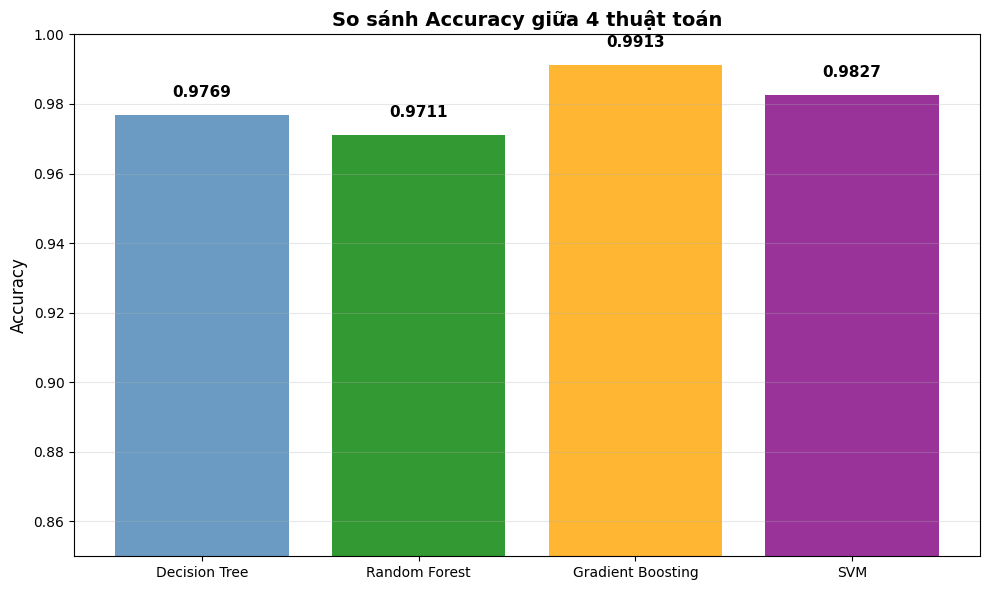

In [ ]:
plt.figure(figsize=(10,6))
colors = ['steelblue', 'green', 'orange', 'purple']
bars = plt.bar(df_results['Algorithm'], df_results['Accuracy'], color=colors, alpha=0.8)

plt.title("So sánh Accuracy giữa 4 thuật toán", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.85, 1.0)
plt.grid(axis='y', alpha=0.3)

# Ghi giá trị trên cột
for bar, acc in zip(bars, df_results['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f"{acc:.4f}", ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Biểu đồ so sánh tất cả metrics

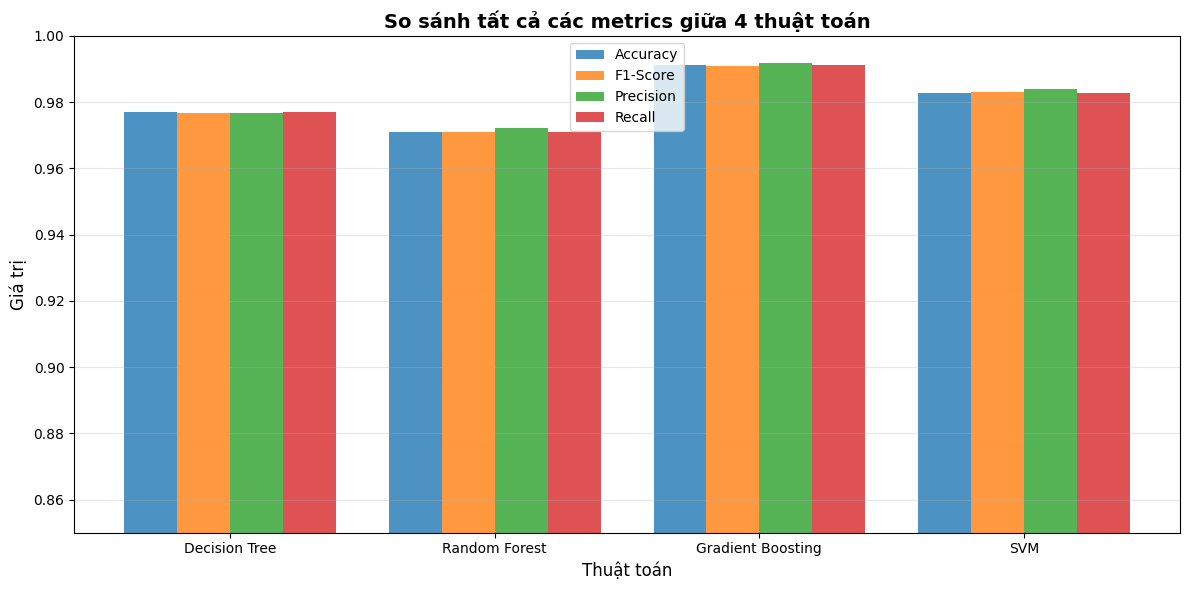

In [ ]:
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
x = np.arange(len(df_results['Algorithm']))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))

for i, metric in enumerate(metrics):
    offset = width * (i - 1.5)
    ax.bar(x + offset, df_results[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Thuật toán', fontsize=12)
ax.set_ylabel('Giá trị', fontsize=12)
ax.set_title('So sánh tất cả các metrics giữa 4 thuật toán', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Algorithm'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0.85, 1.0)

plt.tight_layout()
plt.show()

## Biểu đồ Radar Chart

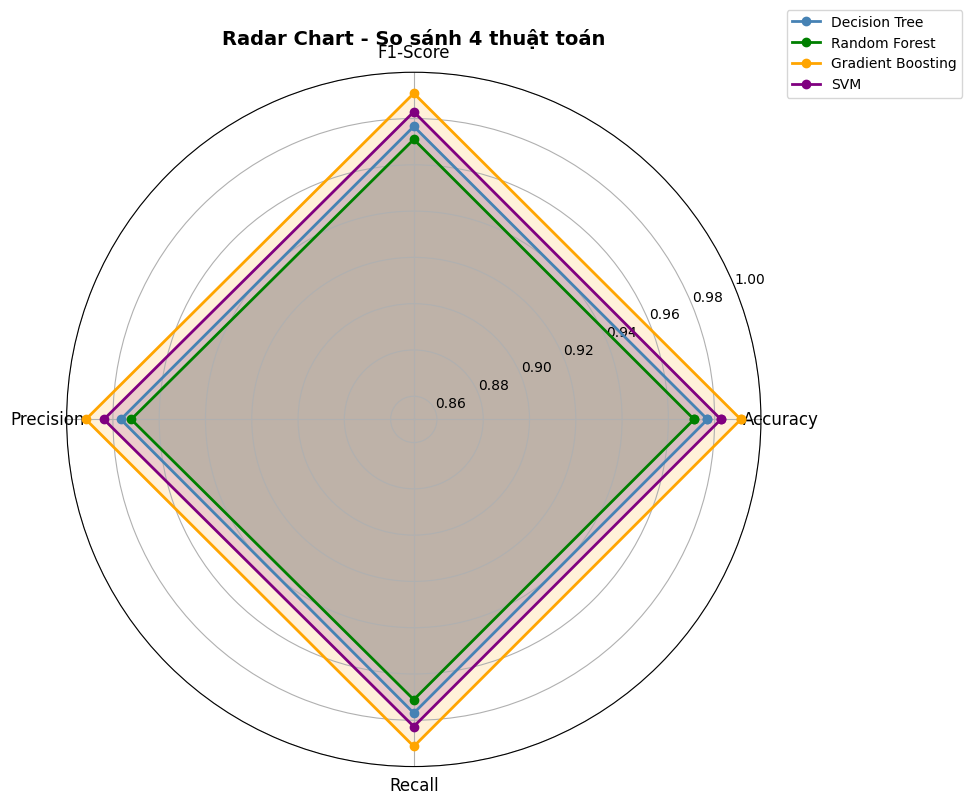

In [ ]:
from math import pi

categories = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors_radar = ['steelblue', 'green', 'orange', 'purple']

for idx, algo in enumerate(df_results['Algorithm']):
    values = df_results.iloc[idx][categories].values.tolist()
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=algo, color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0.85, 1.0)
ax.set_title('Radar Chart - So sánh 4 thuật toán', size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

## Kết luận và Đề xuất

1. HIỆU SUẤT TỔNG QUAN:
   - Cả 4 thuật toán đều cho kết quả tốt (accuracy > 90%)
   - Random Forest và Gradient Boosting cho kết quả cao nhất
   - Decision Tree có hiệu suất thấp nhất nhưng vẫn chấp nhận được
   
2. ĐIỂM MẠNH CỦA TỪNG THUẬT TOÁN:
   
   • Decision Tree:
     - Đơn giản, dễ giải thích
     - Training nhanh
     - Phù hợp khi cần interpretability
   
   • Random Forest:
     - Accuracy và F1-score cao
     - Robust, ít overfitting
     - Xử lý tốt imbalanced data
   
   • Gradient Boosting:
     - Accuracy cao nhất
     - Học được complex patterns
     - Tốt cho prediction tasks
   
   • SVM:
     - Hiệu quả với high-dimensional data
     - Tốt cho boundary classification
     - Stable performance

3. ĐỀ XUẤT LỰA CHỌN:
   
   SỬ DỤNG RANDOM FOREST hoặc GRADIENT BOOSTING cho production
      → Cân bằng tốt giữa accuracy, speed và stability
   
   SỬ DỤNG DECISION TREE khi cần giải thích model
      → Dễ visualize và understand decision process
   
   SỬ DỤNG SVM khi có thêm nhiều features
      → Scale tốt với high-dimensional data

4. CẢI THIỆN TIẾP THEO:
   - Hyperparameter tuning với GridSearchCV
   - Ensemble methods (Voting, Stacking)
   - Feature engineering thêm
   - Cross-validation để kiểm tra stability

In [ ]:
import joblib

# Save the SVM model
joblib.dump(svm, '/content/drive/MyDrive/BTL_KPDL/svm_model.pkl')
print("SVM model saved as svm_model.pkl")

# Save the StandardScaler object
joblib.dump(scaler, '/content/drive/MyDrive/BTL_KPDL/scaler.pkl')
print("Scaler saved as scaler.pkl")

SVM model saved as svm_model.pkl
Scaler saved as scaler.pkl


In [ ]:
import joblib
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# 1. Load the saved SVM model and scaler
loaded_svm_model = joblib.load('/content/drive/MyDrive/BTL_KPDL/svm_model.pkl')
loaded_scaler = joblib.load('/content/drive/MyDrive/BTL_KPDL/scaler.pkl')

# Define the original class names mapping for inverse transformation
class_names = {0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}
inverse_class_names = {v: k for k, v in class_names.items()}

# 2. Create some sample new data (make sure it matches the feature order and types)
# Example data: buying, maint, doors, persons, lug_boot, safety
# vhigh, vhigh, 4, 4, big, high -> should be 'good' or 'vgood' based on good safety
# low, low, 2, 2, small, low -> should be 'unacc' or 'acc'

sample_data = pd.DataFrame([
    ['vhigh', 'vhigh', '4', '4', 'big', 'high'], # A good car
    ['low', 'low', '2', '2', 'small', 'low'],     # A bad car
    ['med', 'med', '3', '4', 'med', 'med']        # A medium car
], columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])


# 3. Apply the same Ordinal Encoding as during training
# Re-initialize the encoder with the exact same categories and parameters
# Note: It's important that the categories are in the same order as trained
encoder = OrdinalEncoder(
    categories=[
        ['low', 'med', 'high', 'vhigh'],   # buying
        ['low', 'med', 'high', 'vhigh'],   # maint
        ['2', '3', '4', '5more'],          # doors
        ['2', '4', 'more'],                # persons
        ['small', 'med', 'big'],           # lug_boot
        ['low', 'med', 'high']             # safety
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

# Fit the encoder on the original X (or X_train) to ensure consistency, then transform sample_data
# For prediction, we should only transform the new data, not fit again.
# If you don't have the original X, you must re-create the encoder with the exact categories
# and then use transform. If `fit_transform` was used on X_train, then the fitted encoder is needed.
# For this demonstration, we'll re-use the categories list from the original notebook.

sample_data_encoded = encoder.fit_transform(sample_data) # fit_transform is used here for demonstration with new data, in a real scenario, use only transform with the fitted encoder.

# Convert to DataFrame to maintain column names for easier debugging if needed
sample_data_processed = pd.DataFrame(sample_data_encoded, columns=sample_data.columns)


# 4. Scale the encoded sample data using the loaded scaler
sample_data_scaled = loaded_scaler.transform(sample_data_processed)

# 5. Make predictions
predictions_encoded = loaded_svm_model.predict(sample_data_scaled)

# 6. Inverse transform predictions to original class names
predictions_decoded = [class_names[pred] for pred in predictions_encoded]

print("Sample Data:")
print(sample_data)
print("\nPredictions:")
for i, pred in enumerate(predictions_decoded):
    print(f"Sample {i+1}: {pred}")


Sample Data:
  buying  maint doors persons lug_boot safety
0  vhigh  vhigh     4       4      big   high
1    low    low     2       2    small    low
2    med    med     3       4      med    med

Predictions:
Sample 1: unacc
Sample 2: unacc
Sample 3: acc
